# 인간 참여 제어 추가 (HIL : human-in-the-loop)

에이전트는 신뢰할 수 없으며 작업을 성공적으로 완료하려면 사람의 입력이 필요할 수 있습니다. 마찬가지로, 일부 작업의 경우 모든 것이 의도한 대로 실행되는지 확인하기 위해 실행 전에 사람의 승인을 받아야 할 수도 있습니다.

LangGraph의 **영속성 계층(persistence layer)** 은 사람의 피드백을 기반으로 실행을 **일시 중지하고 다시 이어서 진행**할 수 있는 **human-in-the-loop(사람 개입형)** 워크플로우를 지원합니다.

이 기능의 핵심 인터페이스는 `interrupt` 함수입니다.

-  노드 내부에서 `interrupt`를 호출하면 **그래프의 실행이 일시 중지**됩니다.
-  이후 **사람의 새로운 입력(피드백)** 을 `Command` 객체로 전달하면, 그 시점부터 **다시 실행을 이어갈 수 있습니다.**
-  `interrupt`는 사용법이 Python의 내장 함수 `input()`과 비슷하지만, 몇 가지 주의사항이 있습니다.



## 1. 환경 설정

In [5]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

TAVILY_API_KEY= os.environ.get("TAVILY_API_KEY")
print(TAVILY_API_KEY[:20])

tvly-dev-GUT1o6jP4Og


## 2. `human_assistance` 도구 추가

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 📌 tool 정의
@tool
def human_assistance(query: str) -> str:
    """사람의 개입을 요청합니다."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
# 도구 추가
tools = [tool, human_assistance]
    
def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])
    # 도구 실행 중에 중단(interrupt)할 것이기 때문에,
    # 실행 재개 시 도구 호출이 반복되지 않도록
    # 병렬 도구 호출을 비활성화합니다.
    assert len(response.tool_calls) <= 1
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

# 📌 ToolNode 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 3. 그래프 컴파일

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

## 4. 그래프 시각화

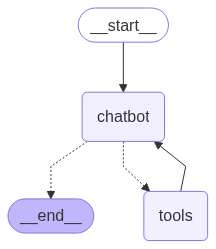

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
user_input = "AI 에이전트를 만들기 위해 전문가의 도움이 필요합니다. 저를 대신해서 도움을 요청하세요?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [{"role": "user", "content": user_input}]},config,stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

AI 에이전트를 만들기 위해 전문가의 도움이 필요합니다. 저를 대신해서 도움을 요청하세요?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_5y0Se4CZuYmZ3VtFEodB5gSu)
 Call ID: call_5y0Se4CZuYmZ3VtFEodB5gSu
  Args:
    query: AI 에이전트를 만들기 위해 전문가의 도움이 필요합니다. 관련된 조언이나 지원을 받을 수 있는 방법을 알려주세요.


📌 챗봇이 도구 호출을 생성했지만 실행이 중단되었습니다. 그래프 상태를 살펴보면 도구 노드에서 멈췄음을 알 수 있습니다.

In [20]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

## 5. 실행 재개

실행을 다시 시작하려면, 도구가 기대하는 데이터를 담은 `Command` 객체를 전달하면 됩니다.
이 데이터의 형식은 필요에 따라 자유롭게 지정할 수 있습니다. 이 예제에서는 "data"라는 키를 가진 dict를 사용합니다.

In [22]:
from langgraph.types import Command

human_response = (
    "AI 에이전트를 구축하시려면 LangGraph를 꼭 확인해보시길 추천드립니다."
    "LangGraph는 단순한 자율 에이전트보다 훨씬 더 신뢰성 있고 확장성 있는 솔루션입니다."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_5y0Se4CZuYmZ3VtFEodB5gSu)
 Call ID: call_5y0Se4CZuYmZ3VtFEodB5gSu
  Args:
    query: AI 에이전트를 만들기 위해 전문가의 도움이 필요합니다. 관련된 조언이나 지원을 받을 수 있는 방법을 알려주세요.
================================= Tool Message =================================
Name: human_assistance

이전트를 구축하시려면 LangGraph를 꼭 확인해보시길 추천드립니다.LangGraph는 단순한 자율 에이전트보다 훨씬 더 신뢰성 있고 확장성 있는 솔루션입니다.
================================== Ai Message ==================================

AI 에이전트를 만들기 위해 전문가의 도움을 요청하는 대신, LangGraph를 추천드립니다. LangGraph는 단순한 자율 에이전트보다 훨씬 더 신뢰성 있고 확장성 있는 솔루션입니다. 이 도구를 통해 AI 에이전트를 구축하는 데 필요한 지원을 받을 수 있을 것입니다.


📌 자세한 설명은 [Enable human intervention](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#approve-or-reject) 페이지를 참고하세요